In [6]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import obspy
from scipy.stats import linregress
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error

import warnings

warnings.filterwarnings("ignore", category=FutureWarning, message=".*use_inf_as_na.*")


In [37]:
import glob

seis_sta=pd.read_csv('redbutte_sta.csv')
seis_sta['stnm']=seis_sta['stnm'].astype(int).apply(lambda i: f"{i:03}")
seis_sta=seis_sta[:-1] 
print(seis_sta)


  stnm        lat         lon    elev
0  002  40.794796 -111.779490  1868.0
1  001  40.794836 -111.779309  1868.0
2  003  40.794740 -111.779110  1847.0
3  004  40.794670 -111.778810  1847.0
4  005  40.794660 -111.778630  1847.0
5  006  40.794660 -111.778400  1847.0


In [38]:
# 002 -> N051
# 001 -> N037
# 003 -> N018
# 004 -> S009
# 005 -> S024
# 006 -> S043

# Mapping dictionary
rename_map = {
    "002": "N051",
    "001": "N037",
    "003": "N018",
    "004": "S009",
    "005": "S024",
    "006": "S043"
}

# Example: renaming a list of station codes
stations = ["002", "001", "003", "004", "005", "006"]

renamed_stations = [rename_map[st] for st in stations]
print(renamed_stations)
# Output: ['N037', 'N051', 'N018', 'S009', 'S024', 'S043']
seis_sta['stnm_renamed']=renamed_stations
print(seis_sta)


['N051', 'N037', 'N018', 'S009', 'S024', 'S043']
  stnm        lat         lon    elev stnm_renamed
0  002  40.794796 -111.779490  1868.0         N051
1  001  40.794836 -111.779309  1868.0         N037
2  003  40.794740 -111.779110  1847.0         N018
3  004  40.794670 -111.778810  1847.0         S009
4  005  40.794660 -111.778630  1847.0         S024
5  006  40.794660 -111.778400  1847.0         S043


In [38]:
    # --- Read swap dates ---
    swap_dates = []
    with open('swap.redb', 'r') as f:
        for line in f:
            parts = line.split()
            for p in parts:
                # Convert YYMMDD → YYYY-MM-DD
                yyyy = int(p[:2])
                yyyy += 2000  # assume 20xx
                mm = int(p[2:4])
                dd = int(p[4:6])
                swap_dates.append(pd.to_datetime(f"{yyyy}-{mm:02d}-{dd:02d}"))


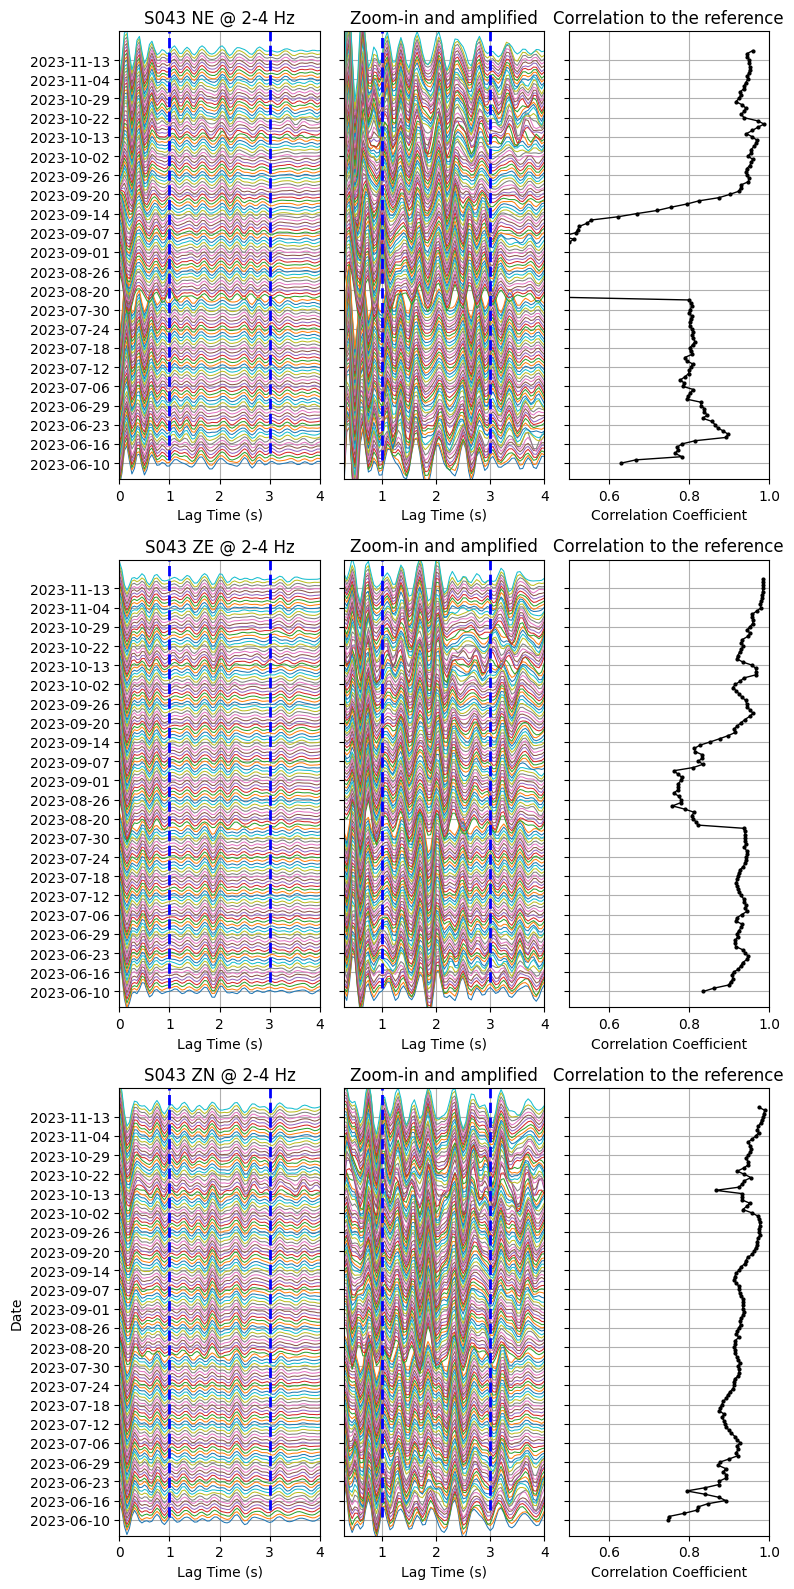

NameError: name 'stop' is not defined

In [52]:


# CORFD='COR_sn5_20Hz_F2-4'
outfd=f'./Check_SCFs'
suffix='ave12-0'
amp=[10,40]

# Read swap dates from file
swap_ranges = []
with open("swap.redb", "r") as f:
    for line in f:
        start, end = line.split()
        swap_ranges.append((int(start)+20000000, int(end)+20000000))  # Convert to int for comparison

color_sets = ["red", "blue", "green", "purple", "orange"]
listdir = ["COR_sn5_20Hz_F2-4", "COR_sn5_20Hz_F4-8"]
sta_list = seis_sta['stnm'].tolist()
comp = ['NE', 'ZE', 'ZN',]

for i, target in enumerate(listdir):
    # target='COR_sn0_20Hz_F2-4'
    # print(target)
    if target == 'COR_sn5_20Hz_F2-4':
        coda_beg=1
        coda_end=3
        xmax=4
    if target == 'COR_sn5_20Hz_F4-8':
        coda_beg=0.5
        coda_end=2
        xmax=3
    for st in reversed(sta_list):
        renamed=seis_sta.loc[seis_sta['stnm'] == st, 'stnm_renamed'].values[0]
        fig, ax= plt.subplots(3,3, figsize=(8, 16), sharey=True )
        if st == '006':
            fd = f'{target}/{st}?-{st}?'
        else:
            fd = f'{target}/{st}-{st}'
        for k, cmp in enumerate(comp):
            
            pattern = os.path.join(fd, f'COR_*_????????.SAC_{cmp}_{suffix}_s')  # Use glob pattern
            
            sacfs = sorted(glob.glob(pattern))  # Use glob instead of os.listdir
            
            ax[k,0].set_xlim(0,4)
            ax[k,1].set_xlim(0.3, xmax)
            ax[k,2].set_xlim(0.5, 1)
            
            ax[k,0].set_title(f'{renamed} {cmp} @ {fmin}-{fmax} Hz')
            ax[k,1].set_title(f'Zoom-in and amplified')
            ax[k,2].set_title(f'Correlation to the reference')
            
            if not sacfs:  # Debugging check
                print(f"Warning: No files found matching {pattern}")
            waveforms = []
            cut_waves = []
            dates = []
            for nsac, sacf in enumerate(sacfs):
                datename=sacf.split('/')[-1].split('_')[3].split('.')[0]
                dates.append(datename)
                
                sac = obspy.read(sacf)
                ccf = sac[0].data
                sampling_rate = sac[0].stats.sampling_rate
                dt = sac[0].stats.delta
                npts = sac[0].stats.npts
                if npts < 20000:
                    lagtime = np.arange(-100+dt, 100, dt)
                if npts > 20000:
                    lagtime = np.arange(-100-dt, 100, dt)
                if npts == 20000:
                    lagtime = np.arange(-100, 100, dt)
                    
                cut_ccf=ccf[(lagtime >= coda_beg) & (lagtime <= coda_end)]
                cut_waves.append(cut_ccf)
                waveforms.append(ccf)
            
            cut_waves_arr = np.array(cut_waves)
            cut_ref=cut_waves_arr.mean(axis=0)
            # normalize (zero-mean, unit-variance)
            cut_ref_norm = (cut_ref - cut_ref.mean()) / cut_ref.std()

            coefs = []
            for w in cut_waves_arr:
                w_norm = (w - w.mean()) / w.std()
                r = np.corrcoef(w_norm, cut_ref_norm)[0, 1]
                coefs.append(r)

            coefs = np.array(coefs)
                
                
            # Convert dates to numerical values for the y-axis
            date_nums = np.arange(len(dates))
            dates = [str(date) for date in dates]
            # Convert YYYYMMDD to YYYY/MM/DD format
            formatted_dates = [f"{d[:4]}-{d[4:6]}-{d[6:]}" for d in dates]

            for col in range(2):
                # Plot each waveform with an offset
                for i, (date, waveform) in enumerate(zip(date_nums, waveforms)):
                    # for swap_idx, swap_range in enumerate(swap_ranges):
                    #     if (swap_range[0] <= int(dates[i])) and (int(dates[i]) <= swap_range[1]):
                    #         color = color_sets[swap_idx]  # Assign corresponding color
                    #         break
                    # print( i, swap_idx, color)
                    ax[k,col].plot(lagtime, waveform * amp[col] + i , linewidth=0.75,)  
                # Select every n th date for labeling
                tick_indices = np.arange(0, len(dates), 6)
                ax[k,col].set_yticks(tick_indices)
                ax[k,col].set_yticklabels([formatted_dates[i] for i in tick_indices])
                ax[k,col].set_xlabel("Lag Time (s)")
                
                ax[k,col].grid('True')
                ax[k,col].set_ylim(-5, len(dates)+5)
                ax[k,col].vlines(coda_beg, coda_beg,  len(dates)+5, colors='b', linestyles='--', linewidth=2)
                ax[k,col].vlines(coda_end, coda_end,  len(dates)+5, colors='b', linestyles='--', linewidth=2)
            
            ax[k,2].set_yticks(tick_indices)
            ax[k,2].set_yticklabels([formatted_dates[i] for i in tick_indices])
            ax[k,2].set_xlabel("Correlation Coefficient")
            ax[k,2].grid('True')
            ax[k,2].plot(coefs, date_nums, marker='o', ms=2,lw=1, linestyle='-', color='k')
            
            
            
            
        ax[k,0].set_ylabel("Date")
        plt.tight_layout()
        plt.savefig(f'{outfd}/Check_SCFs_{st}_{renamed}.png')
        plt.show()
        stop


    # stop
